In [8]:
# naively implementing CNOT on dual-rail
from qutip import tensor, basis, Qobj
import numpy as np
from quantum_logical.basis import SNAILConcatWithAncilla
from quantum_logical.unitary_util import ImplicitUnitaryGate
from qiskit.circuit.library import HGate, CXGate, iSwapGate
from qiskit import QuantumCircuit
from weylchamber import c1c2c3
from qiskit.quantum_info import Operator
from qiskit import transpile

Load the dualrail encoding and convert HGate and CNOT gate into logical gates


In [66]:
# U = |g><0| + |f><1|
# transform Qiskit computational into gf transmon basis
op_gf = (basis(3, 0) * basis(2, 0).dag() + basis(3, 2) * basis(2, 1).dag()).full()
print(op)

[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]


In [80]:
encoding = SNAILConcatWithAncilla()
# U = |+++><0| + |---><1|
op = encoding.logical_basis.transform_operator.full()
# print(op)

In [78]:
# for 2 qubits
# U = |++++++><00| + |+++---><01| + |---+++><10| + |---><11|
print(np.kron(op, op))

[[ 0.125+0.j  0.125+0.j  0.125+0.j  0.125+0.j]
 [ 0.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j]
 [ 0.125+0.j -0.125+0.j  0.125+0.j -0.125+0.j]
 ...
 [ 0.125+0.j  0.125+0.j -0.125+0.j -0.125+0.j]
 [ 0.   +0.j  0.   +0.j -0.   +0.j -0.   +0.j]
 [ 0.125+0.j -0.125+0.j -0.125+0.j  0.125-0.j]]


In [83]:
# A' = U @ A @ U^dag
new_op = op @ HGate().to_matrix() @ op.conj().T
# logical_h = ImplicitUnitaryGate(new_op) #qudit breaks UnitaryGate
logical_h = ImplicitUnitaryGate.create_unitary_from_implicit_operator(new_op)
# print(logical_h)

In [84]:
# A' = U @ A @ U^dag
new_op = np.kron(op, op) @ CXGate().to_matrix() @ np.kron(op, op).conj().T
logical_cnot = ImplicitUnitaryGate.create_unitary_from_implicit_operator(new_op)
print(np.real(logical_cnot))

[[ 1.00000000e+00  0.00000000e+00 -3.08148791e-33 ... -3.08148791e-33
   0.00000000e+00  3.08148791e-33]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-3.08148791e-33  0.00000000e+00  1.00000000e+00 ...  3.08148791e-33
   0.00000000e+00 -3.08148791e-33]
 ...
 [ 3.08148791e-33  0.00000000e+00 -3.08148791e-33 ...  9.37500000e-01
   0.00000000e+00  6.25000000e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [-3.08148791e-33  0.00000000e+00  3.08148791e-33 ...  6.25000000e-02
   0.00000000e+00  9.37500000e-01]]


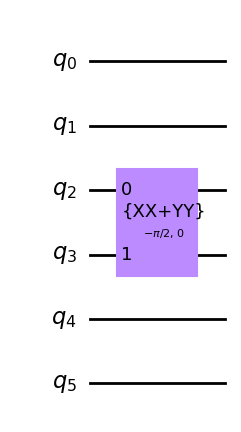

In [112]:
# explore basis gates in the encoding
# gates in the circuit will be applied to the gf transmon basis
N = 6

tensor_op = op_gf
for _ in range(N - 1):
    tensor_op = np.kron(op_gf, tensor_op)

qc = QuantumCircuit(6)
# YOUR GATE HERE
# qc.iswap(2,3)
qc.append(iSwapGate().power(1 / 2), [2, 3])
display(qc.draw("mpl"))

# what does this gate do on the encoding?
cz_op = Operator(qc).data

# first need to transform into gf basis
cz_op_gf = tensor_op @ cz_op @ tensor_op.conj().T

In [113]:
# A = U^dag @ A' @ U
new_op = np.kron(op, op).conj().T @ cz_op_gf @ np.kron(op, op)
logical_cnot = ImplicitUnitaryGate.create_unitary_from_implicit_operator(new_op)
print(np.real(logical_cnot))

# looks like we built a much cheaper CNOT :)
print(c1c2c3(logical_cnot))

[[ 1.00000000e+00 -6.16297582e-33 -1.38777878e-17  5.95262989e-19]
 [-6.16297582e-33  1.00000000e+00  5.95262989e-19 -1.38777878e-17]
 [-1.38777878e-17  5.95262989e-19  1.00000000e+00 -6.16297582e-33]
 [ 5.95262989e-19 -1.38777878e-17 -6.16297582e-33  1.00000000e+00]]
(0.2163469, 0.0, 0.0)
